In [81]:
import numpy as np
import os

In [82]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [83]:
from PIL import Image

In [84]:
def get_data_path():
    return '/Users/thibaultdesfontaines/data'

In [85]:
print(tf.version.VERSION)

2.1.0


In [86]:
data_dir = os.path.join(get_data_path(), "leaf-classification")
train_dir = os.path.join(data_dir, 'train_images')
validation_dir = os.path.join(data_dir, 'validation_images')
test_dir = os.path.join(data_dir, 'test_images')

In [87]:
! tree {validation_dir}

/Users/thibaultdesfontaines/data/leaf-classification/validation_images
├── Acer_Capillipes
│   ├── 201.jpg
│   └── 227.jpg
├── Acer_Circinatum
│   ├── 160.jpg
│   └── 164.jpg
├── Acer_Mono
│   ├── 216.jpg
│   └── 288.jpg
├── Acer_Opalus
│   ├── 1.jpg
│   └── 317.jpg
├── Acer_Palmatum
│   ├── 118.jpg
│   └── 27.jpg
├── Acer_Pictum
│   ├── 146.jpg
│   └── 311.jpg
├── Acer_Platanoids
│   ├── 322.jpg
│   └── 38.jpg
├── Acer_Rubrum
│   ├── 238.jpg
│   └── 698.jpg
├── Acer_Rufinerve
│   ├── 148.jpg
│   └── 364.jpg
├── Acer_Saccharinum
│   ├── 167.jpg
│   └── 78.jpg
├── Alnus_Cordata
│   ├── 186.jpg
│   └── 198.jpg
├── Alnus_Maximowiczii
│   ├── 140.jpg
│   └── 663.jpg
├── Alnus_Rubra
│   ├── 290.jpg
│   └── 55.jpg
├── Alnus_Sieboldiana
│   ├── 34.jpg
│   └── 371.jpg
├── Alnus_Viridis
│   ├── 334.jpg
│   └── 357.jpg
├── Arundinaria_Simonii
│   ├── 196.jpg
│   └── 37.jpg
├── Betula_Austrosinensis
│   ├── 175.jpg
│   └── 18.jpg
├── Betula_Pendula
│   ├── 339.jpg
│   └── 415.jpg
├── Callicarpa_B

In [88]:
CLASS_NAMES = [x for x in sorted(os.listdir(str(train_dir))) if x[0] != '.']
CLASS_NAMES = np.array(CLASS_NAMES)
print("Number of classes: {}".format(len(CLASS_NAMES)))

Number of classes: 99


In [89]:
checkpoint_dir = "/Users/thibaultdesfontaines/data/training_1/"
latest = tf.train.latest_checkpoint(checkpoint_dir)
print("{}".format(latest))

/Users/thibaultdesfontaines/data/training_1/cp.ckpt


In [90]:
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [91]:
def create_model():

    model = Sequential([
        Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        MaxPooling2D(),
        Dropout(0.2),
        Conv2D(32, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Conv2D(64, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Dropout(0.2),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(99)
    ])

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    return model

In [92]:
model = create_model()

model.summary()

model.load_weights(latest)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 28, 28, 64)       

In [93]:
class_0_path = "/Users/thibaultdesfontaines/data/leaf-classification/validation_images/Acer_Capillipes/"

In [94]:
list_ds = tf.data.Dataset.list_files(os.path.join(class_0_path, '*'))

In [95]:
for f in list_ds.take(5):
    print(f.numpy())

/Users/thibaultdesfontaines/data/leaf-classification/validation_images/Acer_Capillipes/201.jpg
/Users/thibaultdesfontaines/data/leaf-classification/validation_images/Acer_Capillipes/227.jpg


In [96]:
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

In [97]:
def get_name(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-1]

In [98]:
def process_path(file_path):
    name = get_name(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, name

In [99]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [100]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [101]:
BATCH_SIZE = 2

In [102]:
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [103]:
train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds))

In [104]:
label_batch

<tf.Tensor: shape=(2,), dtype=string, numpy=array(['201.jpg', '227.jpg'], dtype=object)>

In [105]:
# Expecting 0
predictions = model.predict_classes(image_batch)

In [106]:
images = np.array(image_batch)

In [107]:
import matplotlib.pyplot as plt

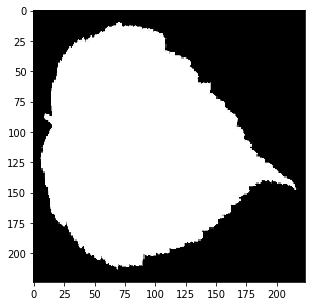

In [108]:
plt.figure(figsize=(15, 5))
plt.imshow(images[0])
plt.show()

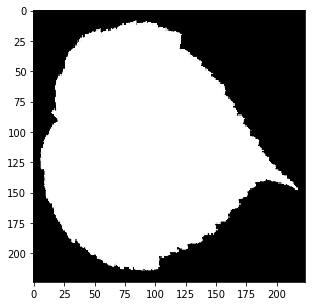

In [109]:
plt.figure(figsize=(15, 5))
plt.imshow(images[1])
plt.show()

In [110]:
predictions

array([11, 94])